# 3_Workflow Notebook

정리된 LangGraph 기반 FAQ 워크플로우 노트북입니다. 아래 단계별로 환경 준비, 모델 설정, 상태 정의, 그래프 구성, 테스트 순으로 정리했습니다.

## 1. 환경 준비
- `.env` 파일에서 API Key를 읽어옵니다.
- 필요한 LangChain, LangGraph 모듈을 임포트합니다.

In [1]:
from dotenv import load_dotenv

load_dotenv() # OPENAI_API_KEY, PINECONE_API_KEY

True

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import Pinecone

## 2. 모델과 임베딩 설정
- 질문 응답용 LLM(`gpt-4.1`)과 경량 테스트용 LLM(`gpt-4.1-mini`)을 초기화합니다.
- `text-embedding-3-large` 모델로 임베딩을 생성해 Pinecone 인덱스와 차원을 맞춥니다.

In [3]:
llm = ChatOpenAI(model="gpt-4.1", temperature=0)
small_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
vector_stroe = Pinecone.from_existing_index(
    index_name="inhouse-python-index",
    embedding=embeddings
)
retriever = vector_stroe.as_retriever()

## 3. 벡터스토어와 리트리버 구성
- 기존 Pinecone 인덱스(`inhouse-python-index`)를 불러옵니다.
- `.as_retriever()`로 LangChain 표준 리트리버를 생성합니다.

In [23]:
from IPython.display import display, Markdown
res = small_llm.invoke("파이썬에 대해서 알려주세요.")
text = res.content if isinstance(res.content, str) else str(res.content)
display(Markdown(text))

파이썬(Python)은 1991년에 귀도 반 로섬(Guido van Rossum)이 개발한 고급 프로그래밍 언어입니다. 파이썬은 문법이 간결하고 읽기 쉬워 초보자부터 전문가까지 널리 사용되고 있습니다. 다음은 파이썬에 대한 주요 특징과 정보입니다.

1. **간결하고 명확한 문법**  
   파이썬은 코드가 직관적이고 가독성이 좋아 배우기 쉽습니다. 들여쓰기를 통해 코드 블록을 구분하는 독특한 문법을 사용합니다.

2. **인터프리터 언어**  
   파이썬은 컴파일 과정 없이 한 줄씩 실행되는 인터프리터 언어로, 빠른 개발과 테스트가 가능합니다.

3. **다양한 용도**  
   웹 개발, 데이터 분석, 인공지능, 머신러닝, 자동화, 게임 개발, 네트워크 프로그래밍 등 다양한 분야에서 활용됩니다.

4. **풍부한 라이브러리와 프레임워크**  
   표준 라이브러리가 매우 방대하며, Django(웹), Flask(웹), NumPy(수치 계산), Pandas(데이터 분석), TensorFlow(머신러닝) 등 다양한 서드파티 라이브러리를 지원합니다.

5. **객체지향 및 함수형 프로그래밍 지원**  
   객체지향 프로그래밍(OOP)뿐만 아니라 함수형 프로그래밍 스타일도 지원합니다.

6. **크로스 플랫폼**  
   Windows, macOS, Linux 등 다양한 운영체제에서 실행할 수 있습니다.

7. **커뮤니티와 생태계**  
   전 세계적으로 활발한 개발자 커뮤니티가 있어 자료와 도움을 쉽게 구할 수 있습니다.

### 간단한 예제 코드

```python
# Hello, World! 출력
print("Hello, World!")

# 변수와 연산
a = 10
b = 20
print(a + b)

# 함수 정의
def greet(name):
    return f"Hello, {name}!"

print(greet("Alice"))
```

파이썬을 배우고 싶다면 공식 홈페이지(https://www.python.org/)에서 설치 파일과 문서를 참고할 수 있으며, 다양한 온라인 강의와 튜토리얼도 많이 제공되고 있습니다.

In [17]:
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

class AgentState(TypedDict, total=False):
    question: str
    answer: str
    context: list[Document]
    document_name: str
    is_in_faq: bool

graph_builder = StateGraph(AgentState)

## 4. 상태 정의와 워크플로우 개요
- `AgentState`에 질문, 컨텍스트, 문서명, FAQ 여부 등을 저장합니다.
- Mermaid 다이어그램으로 흐름을 한눈에 봅니다.

```mermaid
flowchart LR
    a[Question] --> b{is it in FAQ?}
    b -- yes --> c[Generate Answer] --> d[Answer]
    b -- no --> e[Get Document Name] --> e1[Retrive Docs]
    e1 --> c
```

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

### 4-1. 노드: FAQ 여부 확인
- 리트리버 결과를 기반으로 LLM이 "Yes/No"를 판별합니다.

In [10]:
def check_faq(state: AgentState) -> AgentState:
    question = state['question']
    context = retriever.invoke(question, filter={'source': "employee_benefits_and_welfare_faq"})
    check_faq_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that checks if the question is in the FAQ. 
If the question is in the FAQ, return 'Yes'. Otherwise, return 'No'."""),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    check_faq_chain = check_faq_prompt | llm | StrOutputParser()
    is_in_faq = check_faq_chain.invoke({'question': question, 'context': context})
    return {"is_in_faq": is_in_faq == 'Yes', 'context':context if is_in_faq == 'Yes' else []}

In [11]:
# check_faq({"question": "해외 회사와 거래를 할 때 참고해야될 문서는 어떤게 있나요?"})

{'is_in_faq': False, 'context': []}

### 4-2. 노드: 문서 선택
- 질문에 가장 관련된 문서명을 LLM으로 분류합니다.

In [12]:
def get_document_name(state: AgentState) -> AgentState:
    determine_document_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a helpful assistant that determines the most relevant document name based on the user's question. 
Choose from the following document names:
- delegation_of_authority
- employee_benefits_and_welfare_faq
- employee_benefits_and_welfare_guide
- employee_handbook_and_hr_policy
- expense_management_guide
- it_support_guide
- legal_and_compliance_policy

Return ONLY the document name (e.g., 'it_support_guide').

Examples:
- If the question is about who can approve expenses, return 'delegation_of_authority' or 'expense_management_guide' as appropriate.
- If the question is about employee benefits, return 'employee_benefits_and_welfare_guide'.
- If the question is about HR policies or the employee handbook, return 'employee_handbook_and_hr_policy'.
- If the question is about IT support or technical issues, return 'it_support_guide'.
- If the question is about legal or compliance matters, return 'legal_and_compliance_policy'.
- If the question is a frequently asked question about benefits, return 'employee_benefits_and_welfare_faq'.
"""),
        ("user", "Question: {question}"),
    ]
)
    question = state['question']
    determine_document_chain = determine_document_prompt | small_llm | StrOutputParser()
    document_name = determine_document_chain.invoke({'question': question})
    return {"document_name": document_name}

In [24]:
get_document_name({"question": "출산휴가는 얼마나 보장되나요?"})

{'document_name': 'employee_benefits_and_welfare_guide'}

### 4-3. 노드: 문서 검색 및 답변 생성
- 선택된 문서를 검색해 컨텍스트를 가져오고, 최종 답변을 작성합니다.

In [13]:
def retrieve_document(state: AgentState) -> AgentState:
    question = state['question']
    document_name = state['document_name']
    context = retriever.invoke(question, filter={"source": document_name})
    return {"context": context}

In [27]:
retrieve_document({"question": "출산휴가는 얼마나 보장되나요?", "document_name": "employee_benefits_and_welfare_guide"})

{'context': [Document(metadata={'chapter': '제 6 조 (출산 및 육아 휴가)', 'source': 'employee_benefits_and_welfare_guide'}, page_content='- 출산 휴가: 20 일 (유급)\n- 육아 휴가: 최대 1 년 (첫 3개월 50% 급여 지원)'),
  Document(metadata={'chapter': '제 7 조 (경조 휴가)', 'source': 'employee_benefits_and_welfare_guide'}, page_content='다음의 경조사유에 대해 휴가를 부여한다:  \n| 경조 사유    | 휴가 일수 |\n|--------------|-----------|\n| 본인 결혼    | 5 일      |\n| 자녀 결혼    | 2 일      |\n| 부모 사망    | 5 일      |\n| 배우자 사망  | 7 일      |\n| 조부모 사망  | 3 일      |\n| 자녀 출생    | 3 일      |\n| 본인 생일    | 1 일      |\n| 결혼 기념일  | 1 일      |'),
  Document(metadata={'source': 'employee_benefits_and_welfare_guide'}, page_content='직원 복리후생 및 복지 가이드  \n제 1 장 복리후생 개요  \n제 1 조 (목적)\n- 본 가이드는 직원들에게 제공되는 복리후생 제도를 명확히 안내하여, 회사 생활의 만족도를 높이고, 근로 의욕을 증진하기 위함이다.  \n제 2 조 (적용 대상)\n- 정규직, 계약직, 인턴 등 모든 직원에게 적용된다.  \n제 2 장 건강 관리 및 보험  \n제 3 조 (건강 보험)\n- 전 직원은 국민건강보험에 가입되며, 회사가 일정 비용의 보험료를 부담한다.\n- 추가로 회사는 단체 실손 보험을 제공하여, 입원 및 통원 치료비를 지원한다.  \n제 4 조 (정기 건강 검진)\n- 매년 1 회 정기 건강 검진을

## 5. 그래프 구성 및 실행
- LangGraph `StateGraph`에 노드를 등록하고 조건부 분기를 설정합니다.
- `app.invoke()`로 워크플로우를 실행해 결과를 확인합니다.

In [14]:
def generate_answer(state: AgentState) -> AgentState:
    question = state['question']
    context = state['context']
    generate_answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates an answer to the user's question based on the context.
        """),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    generate_answer_chain = generate_answer_prompt | llm | StrOutputParser()
    answer = generate_answer_chain.invoke({"question": question, "context": context})
    return {"answer": answer}

In [28]:
from typing import Literal

def check_if_in_faq(state: AgentState) -> Literal["generate_answer", "get_document_name"]:
    is_in_faq = state['is_in_faq']
    if is_in_faq == 'Yes':
        return "generate_answer"
    else:
        return "get_document_name"

In [18]:
from langgraph.graph import START, END

graph_builder.add_node(check_faq)
graph_builder.add_node(get_document_name)
graph_builder.add_node(retrieve_document)
graph_builder.add_node(generate_answer)

graph_builder.add_edge(START, "check_faq")
graph_builder.add_conditional_edges("check_faq", check_if_in_faq)
graph_builder.add_edge("get_document_name", "retrieve_document")
graph_builder.add_edge("retrieve_document", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()

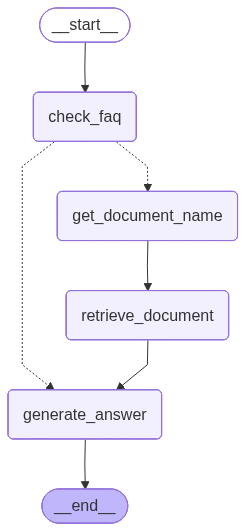

In [19]:
graph

In [21]:
from IPython.display import display, Markdown

result = graph.invoke({"question": "사내 네트워크 담당자는 누구인가요?"})
answer = result.get("answer")

if isinstance(answer, str):
    display(Markdown(answer))
else:
    display(Markdown(str(answer)))

사내 네트워크 담당자는 김영수 (IT 네트워크 관리자)입니다.  
연락처는 다음과 같습니다:
- 이메일: kimys@company.com
- 전화번호: 02-1234-5680

In [22]:
result = graph.invoke({"question": "출산휴가는 얼마나 보장되나요?"})
answer = result.get("answer")

if isinstance(answer, str):
    display(Markdown(answer))
else:
    display(Markdown(str(answer)))

출산휴가는 얼마나 보장되나요?

출산휴가는 출산 예정일 전후로 자유롭게 사용할 수 있으며, 최대 20일 유급으로 제공됩니다.